In [1]:
import Dates
println("Last updated: ", Dates.now(), " (PT)")

Last updated: 2020-07-01T08:02:19.986 (PT)


In [2]:
# Load environment
import Pkg; Pkg.activate("../../../")

 Activating environment at `~/repo/TuringBnpBenchmarks/Project.toml`


In [3]:
# Import Libraries
using Turing
import Turing.RandomMeasures.DirichletProcess
import Turing.RandomMeasures.ChineseRestaurantProcess
using Distributions
using PyPlot
import Random
using BenchmarkTools
import StatsBase.countmap

In [4]:
# rand(ChineseRestaurantProcess(DirichletProcess(1.0), [155, 10]))

In [5]:
function extract(chain, sym; burn=0)
    tail  = chain[sym].value.data[(burn + 1):end, :, :]
    return dropdims(tail, dims=3)
end

extract (generic function with 1 method)

In [87]:
function counts_plot(x; density=false, color="C0", lw=4)
    cm_x = countmap(x)
    number = collect(keys(cm_x))
    count = let
        c = collect(values(cm_x))
        density ? c / sum(c) : c
    end
    plt.vlines(nc, 0, c, color=color, lw=lw)
end

counts_plot (generic function with 4 methods)

In [6]:
# FIXME: Not working???

# Define model
@model infiniteGMM(x) = begin
    nobs = length(x)
    
    # Hyper-parameters, i.e. concentration parameter and parameters of H.
    alpha = 1.0
    mu0 = 0.0
    sig0 = 1.0
    
    # Define random measure, e.g. Dirichlet process.
    rpm = DirichletProcess(alpha)
    
    # Define the base distribution, i.e. expected value of the Dirichlet process.
    H = Normal(mu0, sig0)
    
    # Latent assignment.
    z = tzeros(Int, nobs)
        
    # Locations of the infinitely many clusters.
    mu = tzeros(Float64, 0)
    
    for i in 1:nobs
        # Number of clusters.
        K = maximum(z)
        nk = Vector{Int}(map(k -> sum(z .== k), 1:K))

        # Draw the latent assignment.
        z[i] ~ ChineseRestaurantProcess(rpm, nk)
        
        # Create a new cluster?
        if z[i] > K
            push!(mu, 0.0)

            # Draw location of new cluster.
            mu[z[i]] ~ H
        end
                
        # Draw observation.
        x[i] ~ Normal(mu[z[i]], 1.0)
    end
end

# Generate data
Random.seed!(1)
data = vcat(randn(10), randn(10) .- 5, randn(10) .+ 10)
data .-= mean(data)
data /= std(data);

# Fit model
Random.seed!(2)
iterations = 1000
model_fun = infiniteGMM(data)
chain = sample(model_fun, SMC(), iterations);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


In [36]:
samples = chain.value.data[:, 4:end, 1]
z = samples[:, end-30+1:end]
mu = samples[:, 1:end-30];

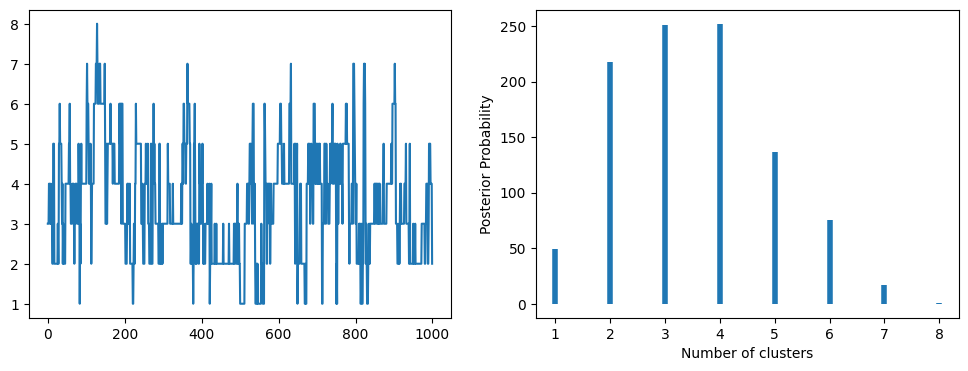

In [88]:
nclus = [length(unique(z[i, :])) for i in 1:size(z, 1)]
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(nclus);
plt.subplot(1, 2, 2);
counts_plot(nclus, density=true);
plt.xlabel("Number of clusters")
plt.ylabel("Posterior Probability");